# 搭乗者数推移データをSARIMAで推定する
* 不明点
    * パラメータチューニングは、ARMAしかできなそうだけど、季節成分、差分はどうやってチューニングする？
    * SARIMAXで追加変数はどうやって入れる?

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
import math
import datetime
%matplotlib inline

# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


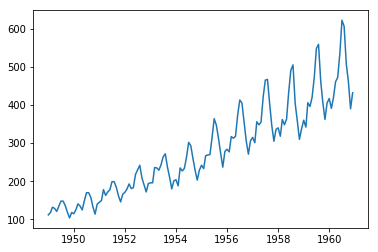

In [187]:
# 日付形式で読み込む
data = pd.read_csv('../01_input/AirPassengers.csv', index_col='Month', parse_dates=True, dtype='float')
ts = data['#Passengers'] 
ts.head()

# プロット
plt.plot(ts)

In [191]:
data.columns

Index(['#Passengers'], dtype='object')

In [192]:
data.head(3)

,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0


In [193]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

## 対数系列の確認

In [194]:
ts2 = data['#Passengers'].map(lambda x :math.log(x))

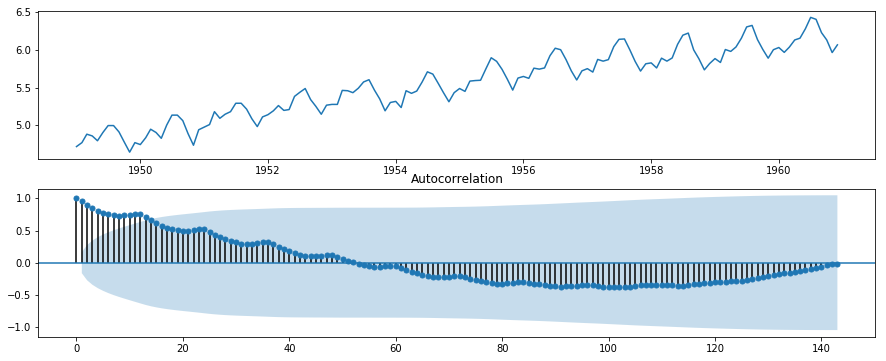

In [195]:
# 対数系列
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(ts2)

#　対数系列（自己相関）
ax2 = fig.add_subplot(2, 1, 2)
sm.graphics.tsa.plot_acf(ts2,ax=ax2)

plt.show()

## 対数差分系列の確認

In [196]:
ts3 = ts2.diff().dropna()

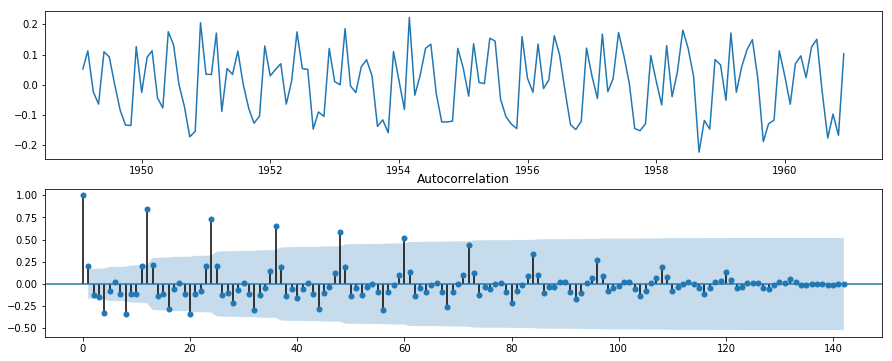

In [197]:
#　対数差分系列
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(ts3)

#　対数差分系列（自己相関）
ax2 = fig.add_subplot(2, 1, 2)
sm.graphics.tsa.plot_acf(ts3,ax=ax2)

plt.show()

## 季節差分系列の確認

In [199]:
ts4 = ts3.diff(periods=12).dropna()

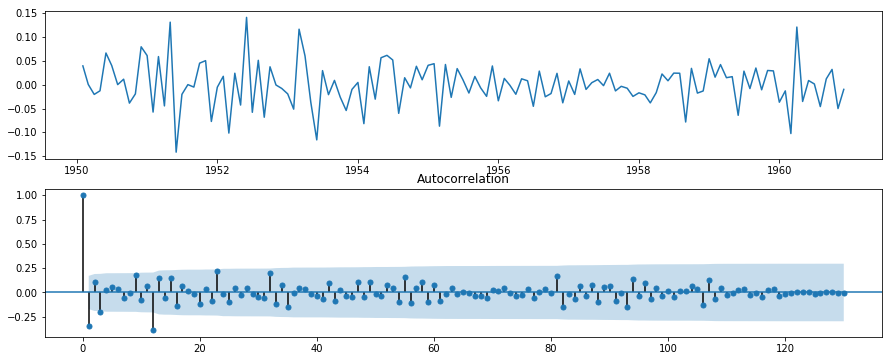

In [200]:
#　対数差分系列
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(ts4)

#　対数差分系列（自己相関）
ax2 = fig.add_subplot(2, 1, 2)
sm.graphics.tsa.plot_acf(ts4,ax=ax2)

plt.show()

## train/testに分割
* モデリング時に差分,季節差分を取るので、1950-02-01以降のデータでモデリングとなる
    * 対数系列データ断面(ts2)：　　1949-01-01 ~ 1960-12-01
    * 差分系列断面(ts3)：　1949-02-01 ~ 1960-12-01
    * 季節差分系列断面(ts4)：　1950-02-01 ~ 1960-12-01

In [201]:
ts3.shape

(143,)

In [150]:
# 学習評価用（差分、季節差分なし）
train2 = ts2['1949-01':'1959-12']
test2 = ts2['1960-01':'1960-12']

## パラメータチューニング

In [151]:
# 自動ARMAパラメータ推定関数
res_selection = sm.tsa.arma_order_select_ic(train2, ic='aic', trend='nc')
res_selection

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retval

{'aic':             0           1           2
 0         NaN  651.776277  487.099772
 1 -204.668800 -209.509545 -211.836106
 2 -197.545805 -213.899702 -212.008458
 3 -209.333879 -211.995493 -211.350046
 4 -199.014692 -210.261264         NaN, 'aic_min_order': (2, 1)}

## フィッティング

In [169]:
# SARIMAモデル作成
sarimax = sm.tsa.SARIMAX(train2, 
                         order=(2, 1, 1),
                         seasonal_order=(1, 0, 1, 12),
                         enforce_stationarity = False,
                         enforce_invertibility = False
                        ).fit()

In [170]:
print(sarimax.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        #Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 220.300
Date:                            Wed, 17 Jul 2019   AIC                           -428.600
Time:                                    01:57:26   BIC                           -411.303
Sample:                                01-01-1949   HQIC                          -421.571
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4870      0.135      3.614      0.000       0.223       0.751
ar.L2          0.1853      0.099   

In [171]:
# モデルの残差成分
sarimax_resid = sarimax.resid

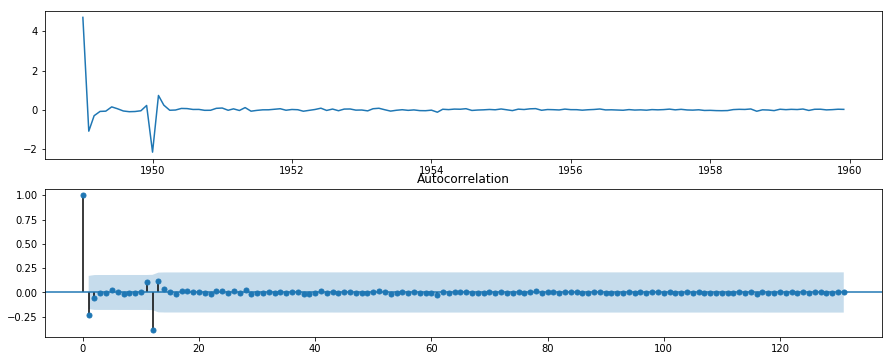

In [172]:
# モデル残差のコレログラム
fig = plt.figure(figsize=(15,6))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(2,1,1)
plt.plot(sarimax_resid)

# 自己相関(ACF)のグラフ
ax2 = fig.add_subplot(2,1,2)
sm.graphics.tsa.plot_acf(sarimax_resid, ax=ax2)

plt.show()

In [173]:
print(sarimax.aic)

-428.60004341910565


## 確認
* モデリング時に差分,季節差分を取るので、1950-02-01以降のデータでモデリングとなる
    * 対数系列データ断面(ts2)：　　1949-01-01 ~ 1960-12-01
    * 差分系列断面(ts3)：　1949-02-01 ~ 1960-12-01
    * 季節差分系列断面(ts4)：　1950-02-01 ~ 1960-12-01

In [174]:
train2.index.min(), train2.index.max()

(Timestamp('1949-01-01 00:00:00'), Timestamp('1959-12-01 00:00:00'))

In [175]:
test2.index.min(), test2.index.max()

(Timestamp('1960-01-01 00:00:00'), Timestamp('1960-12-01 00:00:00'))

### 予測値（学習データ）と実績の比較

In [183]:
# 予測
sarimax_pred = sarimax.predict('1950-04', '1959-12') 
sarimax_pred2 = sarimax_pred.map(lambda x: math.exp(x))

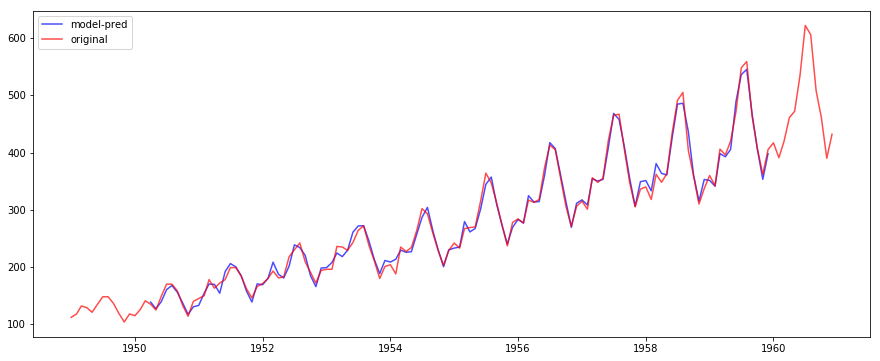

In [184]:
# モデルの値でプロット
fig = plt.figure(figsize=(15,6))
plt.plot(sarimax_pred2, c="b", label="model-pred", alpha=0.7)

plt.plot(ts, c='r', label="original", alpha=0.7)
plt.legend(loc='best')

### 予測値（テストデータ）と実績の比較

In [185]:
# 予測
sarimax_pred = sarimax.predict('1959-12', '1960-12') 
sarimax_pred2 = sarimax_pred.map(lambda x: math.exp(x))

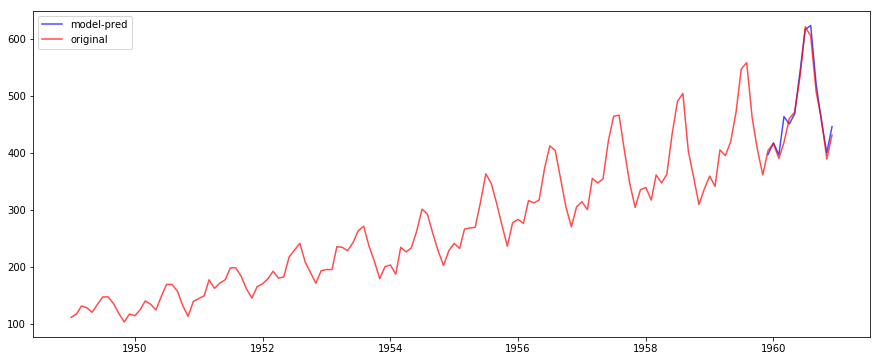

In [186]:
# モデルの値でプロット
fig = plt.figure(figsize=(15,6))
plt.plot(sarimax_pred2, c="b", label="model-pred", alpha=0.7)

plt.plot(ts, c='r', label="original", alpha=0.7)
plt.legend(loc='best')